<a href="https://colab.research.google.com/github/mingd00/ML/blob/main/LightBGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ad_click.csv')
data.head()


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [24]:
# 타겟 변수와 특성 분리
X = data.drop('Clicked on Ad', axis=1)
y = data['Clicked on Ad']

# 데이터 타입 확인
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
dtypes: float64(4), object(5)
memory usage: 703.2+ KB


데이터 타입이 object인 컬럼 category로 변경하기

In [25]:
object_cols = [col for col in X.columns if X[col].dtype == 'object']

X[object_cols] = X[object_cols].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Daily Time Spent on Site  10000 non-null  float64 
 1   Age                       10000 non-null  float64 
 2   Area Income               10000 non-null  float64 
 3   Daily Internet Usage      10000 non-null  float64 
 4   Ad Topic Line             10000 non-null  category
 5   City                      10000 non-null  category
 6   Gender                    10000 non-null  category
 7   Country                   10000 non-null  category
 8   Timestamp                 10000 non-null  category
dtypes: category(5), float64(4)
memory usage: 471.7 KB


학습, 검증 데이터 설정

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

LGBM 회귀 모델 학습

In [30]:
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation

# 모델 초기화
lgbm = LGBMRegressor(
    n_estimators=1000, # 모델이 훈련할 트리 수
    learning_rate=0.01, # 예측을 얼마나 수행할지 결정, 높을수록 적은 수의 트리로 학습이 빠르게 이루어질 수 있지만 과적합이 발생할 수 있다.
    max_depth=8, # 결정 트리의 최대 깊이(과적합 방지)
    random_state=42
)

# 조기 종료 및 학습 로그 출력 콜백 정의
early_stop = early_stopping(stopping_rounds=10)
log_eval = log_evaluation(period=30)

# 모델 학습
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stop, log_eval]
)

# 정확도 출력
print(lgbm.score(X_val, y_val))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.491375
Training until validation scores don't improve for 10 rounds
[30]	valid_0's rmse: 0.425789	valid_0's l2: 0.181296
[60]	valid_0's rmse: 0.377412	valid_0's l2: 0.14244
[90]	valid_0's rmse: 0.34332	valid_0's l2: 0.117869
[120]	valid_0's rmse: 0.320314	valid_0's l2: 0.1026

평가지표 변화 확인

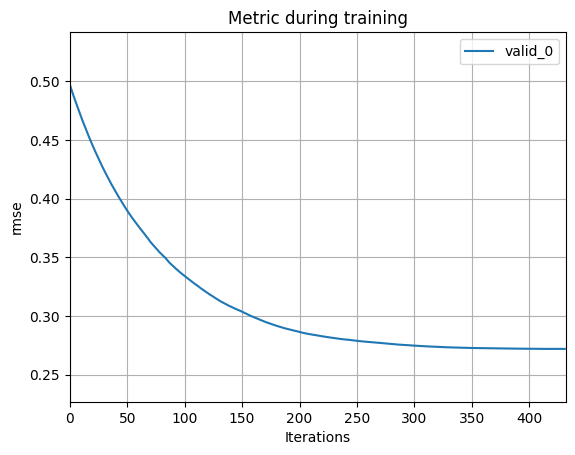

In [28]:
import lightgbm as lgb
import matplotlib.pyplot as plt

loss_plot = lgb.plot_metric(lgbm.evals_result_, metric='rmse')
plt.show()

피처 중요도 확인

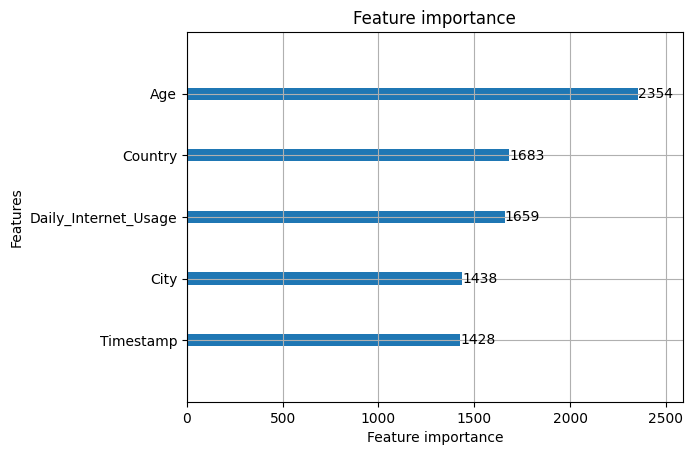

In [29]:
# 최대 피처 수 -> 5개
importance_plot = lgb.plot_importance(lgbm.booster_, max_num_features=5)
plt.show()